In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import datetime
import matplotlib.dates as mdates


In [2]:
matplotlib.rcParams["figure.figsize"] = 20,9
import warnings
warnings.filterwarnings('ignore')

# Load the data

In [3]:
# import data from github url, url1 -Confirmed, url2 -Deaths. url3 -Recovered
data_path = './data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
file1 = data_path + 'time_series_19-covid-Confirmed.csv'
file2 = data_path + 'time_series_19-covid-Deaths.csv'
file3 = data_path + 'time_series_19-covid-Recovered.csv'

df1 = pd.read_csv(file1, error_bad_lines=False)
df2 = pd.read_csv(file2, error_bad_lines=False)
df3 = pd.read_csv(file3, error_bad_lines=False)

#display(df1.head(), df2.head(), df3.head())

Convert date columns to a time series

In [4]:
df1u = pd.melt(df1, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Confirmed')
df2u = pd.melt(df2, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Deaths')
df3u = pd.melt(df3, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Recovered')

df1u['DateTime'] = pd.to_datetime(df1u['DateTime'])
df2u['DateTime'] = pd.to_datetime(df2u['DateTime'])
df3u['DateTime'] = pd.to_datetime(df3u['DateTime'])

data = pd.concat([df1u, df2u, df3u], axis=1, join='inner')
data = data.loc[:,~data.columns.duplicated()] # Remove columns that were repeated in the three datasets
data['mortality_fraction'] = data['Deaths']/data['Confirmed']

In [5]:
data

,Province/State,Country/Region,Lat,Long,DateTime,Confirmed,Deaths,Recovered,mortality_fraction
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0,0.0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0,0.0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0,NaN
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0,NaN
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...
20701,"Oakland, MI",US,42.5922,-83.3362,2020-03-12,0,0,0,NaN
20702,"Wayne, MI",US,42.2791,-83.3362,2020-03-12,0,0,0,NaN
20703,"New Castle, DE",US,39.5393,-75.6674,2020-03-12,0,0,0,NaN
20704,NaN,Cuba,22.0000,-80.0000,2020-03-12,3,0,0,0.0


Names of available countries (Note, some countries are divided in province/State

In [6]:
data['Country/Region'].unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'Netherlands', 'San Marino', 'Belarus', 'Iceland',
       'Lithuania', 'Mexico', 'New Zealand', 'Nigeria', 'Ireland',
       'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal',
       'Argentina', 'Chile', 'Jordan', 'Ukraine', 'Hungary',
       'Liechtenstein', 'Poland', 'Tunisia', 'Bosnia and Herzegovina',
       'Slovenia', 'South Africa', 'Bhutan', 'Cameroon', 'Colo

List of most affected countries (sorted by number of confirmed cases)

In [7]:
data.groupby(['Country/Region'])[['Confirmed', 'Deaths', 'Recovered']].sum().sort_values(by='Confirmed')[::-1][0:15]

,Confirmed,Deaths,Recovered
Country/Region,,,
China,2638504,83848,1025042
"Korea, South",88693,595,1829
Italy,79286,4066,6499
Iran,64281,2341,18101
Cruise Ship,18476,109,944
France,11993,225,246
Germany,10936,10,393
Spain,9896,210,532
Japan,7679,127,1152


In [8]:
def select_country(data, country='', province='', start_date='2020-02-15', end_date='2020-03-11'):
    # Select by country
    if country != '':
        cond1 = data['Country/Region'] == country
    else:
        cond1 = data['Country/Region'].notna()  # Select any country
    # Select by province
    if province != '':
        cond2 = data['Province/State'] == province
    else:
        cond2 = data['Province/State'] != ''  # Select any province
    # Select by time range
    if start_date != '':
        t0 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    else:
        t0 = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')
    if end_date != '':
        t1 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    else:
        t1 = datetime.datetime.strptime('9999-01-01', '%Y-%m-%d')
    cond3 = (data['DateTime'] >= t0) & (data['DateTime'] < t1)
    selection = cond1&cond2&cond3
    print('Number of entries per country: {}'.format(cond1.sum()))
    print('Number of entries per province: {}'.format(cond2.sum()))
    print('Number of entries per time range: {}'.format(cond3.sum()))
    print('Number of entries selected: {}'.format(selection.sum()))
    return data[selection]

In [10]:
def my_exponential(t,  b, alpha):
    return  b * np.exp(alpha * (t-t[0])/t[0])

def make_fit(x, y):
    popt, pcov = curve_fit(my_exponential, x, y, p0=(1., 1))
    return popt

#def fit_exp(data, column):
#    x = mdates.date2num(data['DateTime'])
#    y = data[column].values
#    popt = make_fit(x, y)
#    c_fit = my_exponential(x, *popt)
#    return c_fit, popt

def fit_data(data):
    for column in ['Confirmed', 'Deaths', 'Recovered']:
        x = mdates.date2num(data['DateTime'])
        y = data[column].values
        popt = make_fit(x, y)
        c_fit = my_exponential(x, *popt)
        data.loc[:, column+'_fit'] = c_fit
    return data

In [11]:
def plot_country(data, country='Spain', province='', start_date='2020-02-15', end_date='2020-03-12'):
    data_country = fit_data(select_country(data, country=country, province=province, start_date=start_date, end_date=end_date))
    
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (1, 1))
    plt.subplots_adjust(hspace=0)

    ax1.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color='#3498db', label='Confirmed')
    ax1.plot(data_country['DateTime'], data_country['Deaths'], 'o', color='tomato', label='Deaths')
    ax1.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color='#3498db')
    ax1.plot(data_country['DateTime'], data_country['Deaths_fit'], '-', color='tomato')
    ax2.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color='#3498db')
    ax2.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color='#3498db')
    ax3.plot(data_country['DateTime'], data_country['Deaths'], 'o', color='tomato')
    ax3.plot(data_country['DateTime'], data_country['Deaths_fit'], '-', color='tomato')
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    fig.suptitle(f'{country}\nDate range: {start_date} to {end_date}', fontsize=16)
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.set_ylim(0.5,)
    fig.savefig(country+'.png', bbox_inches='tight', dpi=150)
    return data_country

Number of entries per country: 51
Number of entries per province: 20706
Number of entries per time range: 10556
Number of entries selected: 26


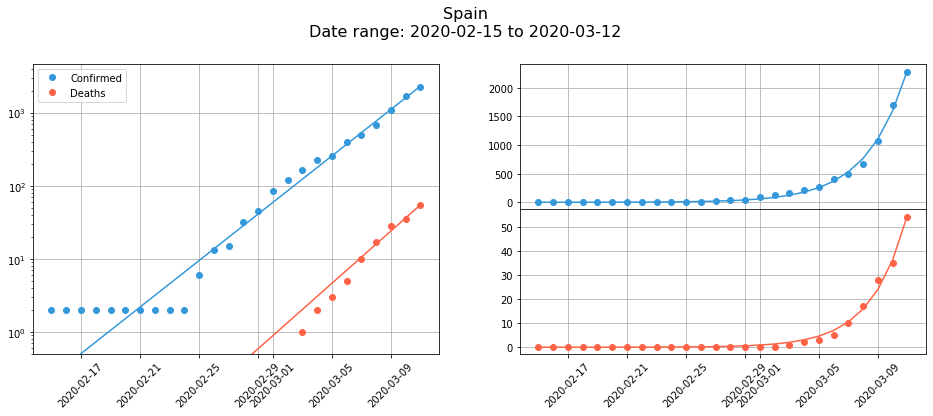

In [12]:
spain = plot_country(data, country='Spain')

Number of entries per country: 51
Number of entries per province: 20706
Number of entries per time range: 10556
Number of entries selected: 26


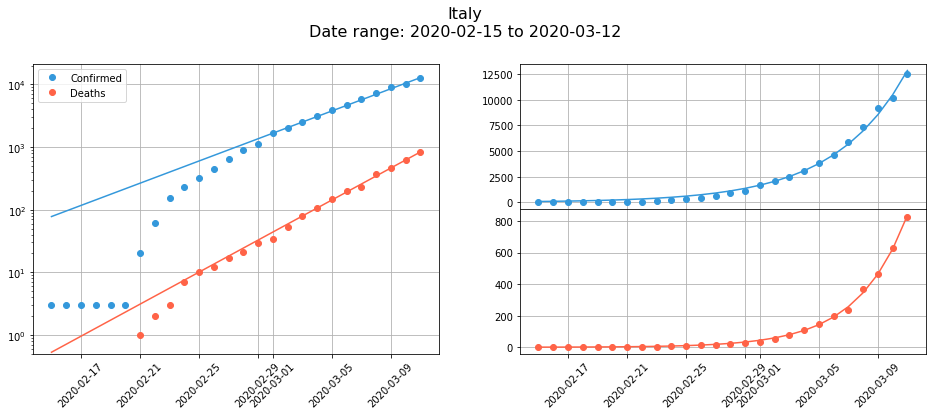

In [13]:
italy = plot_country(data, country='Italy')

In [14]:
def compare_countries(data, country1='Spain', province1='', start_date1='2020-02-15', end_date1='2020-03-12',
                       country2='Spain', province2='', start_date2='2020-02-15', end_date2='2020-03-12',
                       delay=0):
    data_country1 = fit_data(select_country(data, country=country1, province=province1, start_date=start_date1, end_date=end_date1))
    data_country2 = fit_data(select_country(data, country=country2, province=province2, start_date=start_date2, end_date=end_date2))
    
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (1, 1))
    plt.subplots_adjust(hspace=0)
    ax1.plot(data_country1['DateTime'], data_country1['Confirmed'], 'o', color='#3498db', label=country1+' Confirmed')
    ax1.plot(data_country1['DateTime'], data_country1['Confirmed_fit'], '-', color='#3498db')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed'], 's', color='k', label=country2+' Confirmed')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed_fit'], '-', color='k')
    ax1.plot(data_country1['DateTime'], data_country1['Deaths'], 'o', color='tomato', label=country1+' Deaths')
    ax1.plot(data_country1['DateTime'], data_country1['Deaths_fit'], '-', color='tomato')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths'], 's', color='g', label=country2+' Deaths')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths_fit'], '-', color='g')
    ax1.set_yscale('log')
    
    ax2.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed'], 's', color='k', label=country2)
    ax2.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed_fit'], '-', color='k') 
    ax2.plot(data_country1['DateTime'], data_country1['Confirmed'], 'o', color='#3498db', label=country1)
    ax2.plot(data_country1['DateTime'], data_country1['Confirmed_fit'], '-', color='#3498db')
    
    ax3.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths'], 's', color='g', label=country2)
    ax3.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths_fit'], '-', color='g')
    ax3.plot(data_country1['DateTime'], data_country1['Deaths'], 'o', color='tomato', label=country1)
    ax3.plot(data_country1['DateTime'], data_country1['Deaths_fit'], '-', color='tomato')
    
    ax1.legend()
    ax1.set_ylim(0.5,)
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)

    fig.suptitle(f'{country1} vs {country2}\nTime delay added: {delay} days', fontsize=16)
    fig.savefig(f'{country1}_{country2}.png', bbox_inches='tight', dpi=150)

    

Number of entries per country: 51
Number of entries per province: 20706
Number of entries per time range: 10556
Number of entries selected: 26
Number of entries per country: 51
Number of entries per province: 20706
Number of entries per time range: 10556
Number of entries selected: 26


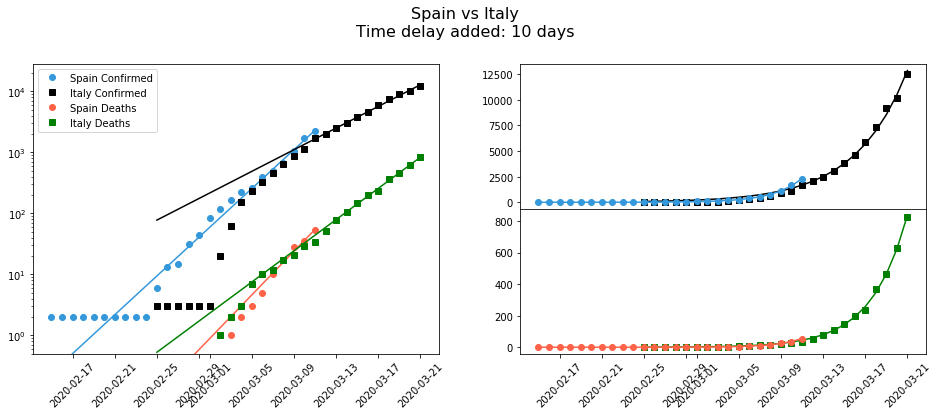

In [15]:
compare_countries(data, country2='Italy', delay=10)

Number of entries per country: 51
Number of entries per province: 20706
Number of entries per time range: 10556
Number of entries selected: 26
Number of entries per country: 51
Number of entries per province: 20706
Number of entries per time range: 10556
Number of entries selected: 26


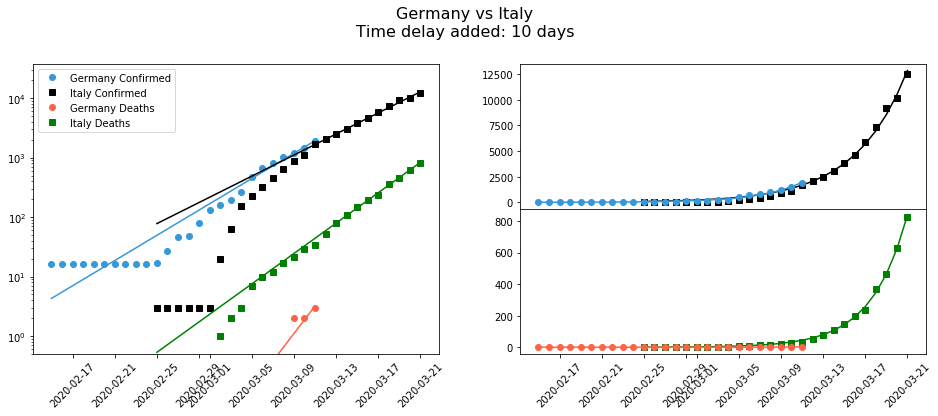

In [16]:
compare_countries(data, country1='Germany', country2='Italy', delay=10)

Number of entries per country: 51
Number of entries per province: 20706
Number of entries per time range: 10556
Number of entries selected: 26
Number of entries per country: 51
Number of entries per province: 20706
Number of entries per time range: 10556
Number of entries selected: 26


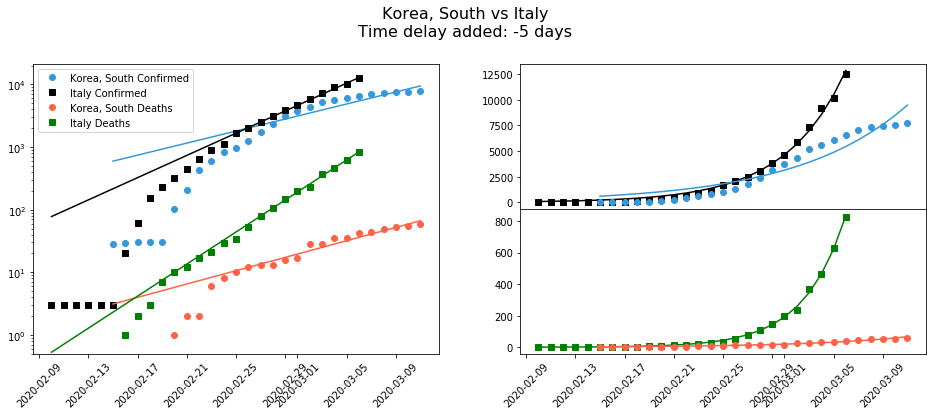

In [17]:
compare_countries(data, country1='Korea, South', country2='Italy', delay=-5)